# Comparison of dNBR for three wild fires in 2018 and 2019

This notebook contains the calculations necessary for mapping the burn severity of the previously selected products.
This burn severity is measured as the Normalized Burn Ratio (NBR).
The development of this burn ratio over time is described using the ${\Delta}$NBR, which is defined as:

$$
{\Delta}\text{NBR} = \text{NBR}_\text{pre-fire} - \text{NBR}_\text{post-fire}
$$

Instead of only calculating values by overlaying different bands in one product, the ${\Delta}$NBR adds a time dimension to determine changes that have occurred in the time span between the two chosen products.

## Methodology

The NBR of the products downloaded in the previous notebook is calculated using the notebook [02 Spectral Indices]("02 Spectral Indices.ipynb").
These NBR values are plotted side-by-side to get a visual impression of the changes that may have occurred between two given dates.
The ${\Delta}$NBR is calculated and, if showing signs of burned areas, compared to data given by the responsible German ministries.

## Calculcations
### Setup

In [1]:
from pathlib import Path
import geopandas as gpd

from sentinel_helpers import geodataframe_on_map, scihub_band_paths
nbr_path = Path('output/spectral_indices/')
product_path = Path('input/forest_fires/')

### Treuenbrietzen (Postdam-Mittelmark) 2018

The first case is the wild fire in August 2018 that led to the evacuation of three villages (source).
We load the pre-calculated NBR values and geometries we fetched from OpenStreetMap:

In [2]:
potsdam_mittelmark_nbr_2018 = list(sorted(nbr_path.glob('*2018*NBR*.tif')))
potsdam_mittelmark_nbr_2018

[]

The `postdam_mittelmark_geom` is a collection of three points:

In [3]:
potsdam_mittelmark_geom = gpd.read_file(product_path / 'evacuated_2018.json')
# geodataframe_on_map(postdam_mittelmark_geom)
potsdam_mittelmark_geom

,place_id,osm_type,osm_id,display_name,place_rank,category,type,importance,icon,geometry
0,3285415,node,387079362,"Frohnsdorf, Treuenbrietzen, Potsdam-Mittelmark...",19,place,village,0.495,https://nominatim.openstreetmap.org/ui/mapicon...,POINT (12.90217 52.05466)
1,554316,node,226935349,"Klausdorf, Treuenbrietzen, Potsdam-Mittelmark,...",19,place,village,0.495,https://nominatim.openstreetmap.org/ui/mapicon...,POINT (12.94213 52.04879)
2,303964452,node,282202396,"Tiefenbrunnen, Treuenbrietzen, Potsdam-Mittelm...",22,place,isolated_dwelling,0.420,None,POINT (12.94439 52.03532)


#### NBR plots

We plot the NBR values for all dates side by side to get a first visual impression of changes that have occurred.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sentinel_helpers import scihub_band_paths, scihub_band_date, RasterReaderList
import rasterio as r
import rasterio.plot as rplt

# we can save some time by reading only parts of the product we are interested in
from rasterio.features import geometry_window

def plot_nbrs(products, geom):
    with RasterReaderList(products) as readers:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))

        # we need to reproject from WGS84 so the geometry can be correctly plotted on the map
        _geom = geom.to_crs(readers[0].crs)

        # we don't need the entire NBR, we only use a slice
        window = geometry_window(readers[0], _geom.buffer(5000))
        window_transform = readers[0].window_transform(window)

        nbrs = np.array([reader.read(masked=True, window=window) for reader in readers])
        
        # ensure that subplot colors are chosen on a fixed scale
        vmin = nbrs.min()
        vmax = nbrs.max()
        
        for reader, nbr, ax in zip(readers, nbrs, axes):
            product_dt = scihub_band_date(reader)
            ax.tick_params(axis='x', labelrotation=90)
            rplt.show(nbr,
                      ax=ax,
                      transform=window_transform,
                      cmap='Greys',
                      title=product_dt.strftime('%Y-%m-%d'),
                      vmin=vmin,
                      vmax=vmax)
            _geom.plot(ax=ax, facecolor='none', edgecolor='red')
            
        # increase horizontal whitespace between subplots
        plt.subplots_adjust(wspace=0.32)
        
        # add colorbar using the last image
        img = axes[-1].get_images()[0]
        fig.colorbar(img, ax=axes, shrink=0.2)

Red dots mark the location of the evacuated villages, the background shows the calculated NBR values, where areas with a low NBR value are brighter and areas with a high NBR value are darker.

IndexError: list index out of range

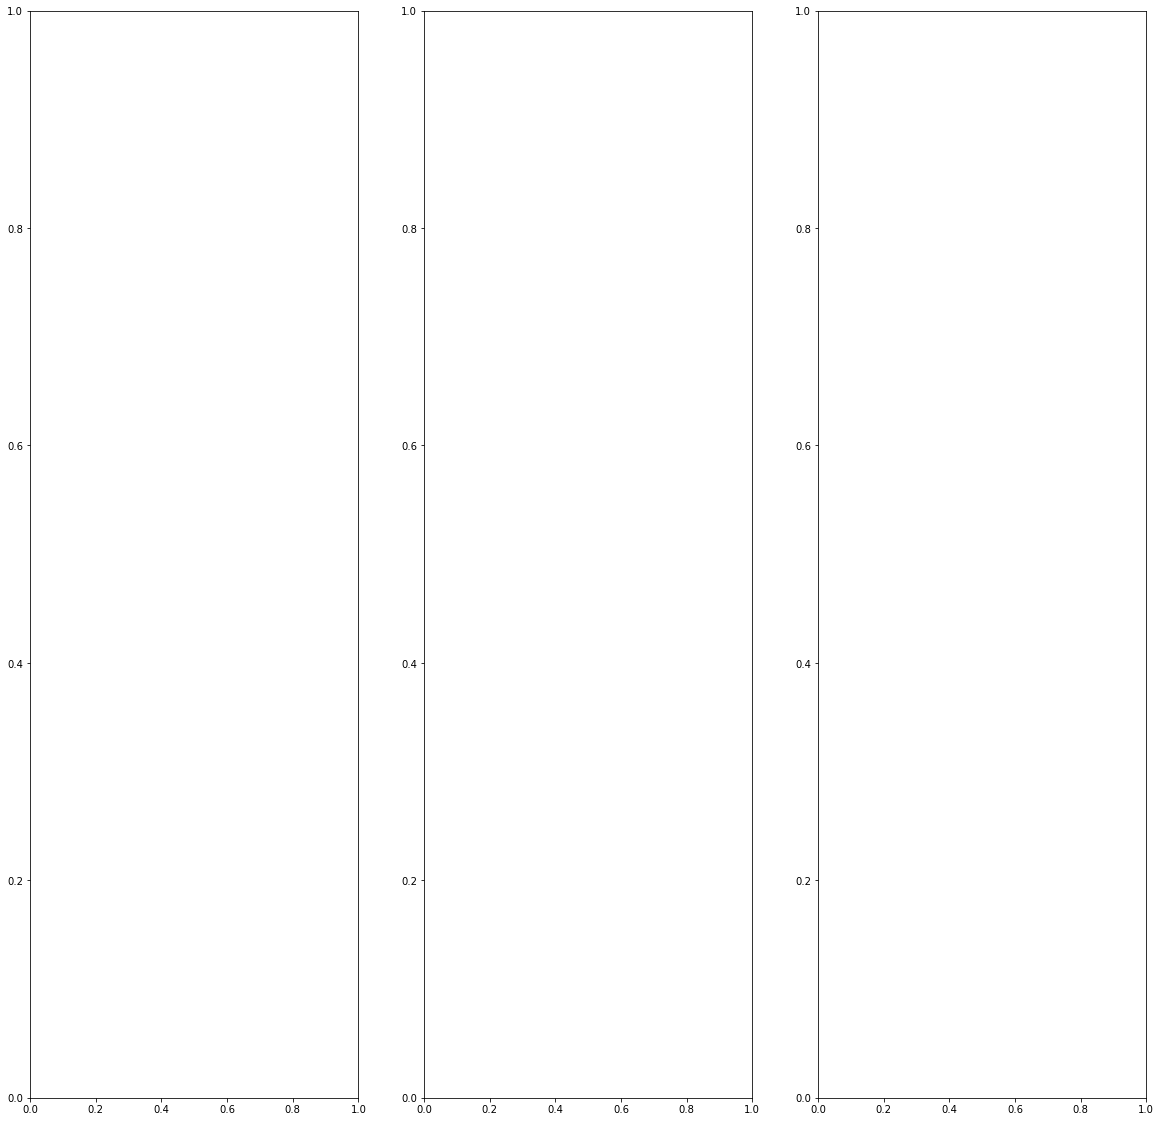

In [5]:
plot_nbrs(potsdam_mittelmark_nbr_2018, potsdam_mittelmark_geom)

The NBR can be interpreted as follows:

> Healthy vegetation shows a very high reflectance in the NIR[^nir], and low reflectance in the SWIR[^swir] portion of the spectrum - the opposite of what is seen in areas devastated by fire. Recently burnt areas demonstrate low reflectance in the NIR and high reflectance in the SWIR, i.e. the difference between the spectral responses of healthy vegetation and burnt areas reach their peak in the NIR and the SWIR regions of the spectrum.
>
> ![image.png](https://un-spider.org/sites/default/files/Spectral_responses.jpg)  
> Figure 2. Comparison of the spectral response of healthy vegetation and burned areas. Source: U.S. Forest service.
> 
> To benefit from the magnitude of spectral difference, NBR uses the ratio between NIR and SWIR bands, according to the formula shown below. A high NBR value indicates healthy vegetation while a low value indicates bare ground and recently burnt areas. Non-burnt areas are normally attributed to values close to zero.
>
> $\text{NBR} = \frac{\text{NIR} - \text{SWIR}}{\text{NIR} + \text{SWIR}}$

Source: [UN-Spider Knowledge Portal](https://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio)

[^nir]: Near Infra-Red
[^swir]: Short-wave Infra-Red

### dNBR calculation

In order to calculate ${\Delta}$NBR, the NBR after the fire is sutracted from the NBR before the fire.
Reminder:

$$
{\Delta}\text{NBR} = \text{NBR}_\text{pre} - \text{NBR}_\text{post}
$$

In [ ]:
def calculate_dnbr(pre_nbr, post_nbr, geom=[]):
    with RasterReaderList([pre_nbr, post_nbr]) as readers:
        if len(geom):
            # if a geometry is passed, perform all calculations only in the
            # surroundings if this geometry
            _geom = geom.to_crs(readers[0].crs)
            window = geometry_window(readers[0], _geom.buffer(5000))
            window_transform = readers[0].window_transform(window)
        else:
            window = window_transform = None
        
        pre_fire = readers[0].read(masked=True, window=window)
        post_fire = readers[1].read(masked=True, window=window)

        # we need to mask invalid pixels in any of the input files for the resulting file
        dnbr = pre_fire - post_fire
        dnbr.mask = pre_fire.mask | post_fire.mask
        
        return (dnbr, window, window_transform)

> dNBR values can vary from case to case, and so, if possible, interpretation in specific instances should also be carried out through field assessment; in order to obtain the best results. However, the United States Geological Survey (USGS) proposed a classification table to interpret the burn severity, which can be seen below (Table 1).
>
> ![image.png](https://un-spider.org/sites/default/files/table+legend.PNG)
> Table 1. Burn severity levels obtained calculating dNBR, proposed by USGS.

Source: [UN-Spider Knowledge Portal](https://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio)

We construct a custom color scheme for matplotlib to match the values given in the table above and define a function that helps us plot the $\Delta$NBR values using different color scales:

In [ ]:
from matplotlib.colors import BoundaryNorm, ListedColormap

# define discrete color scale based on table above
dnbr_cmap = ListedColormap(['#778835', '#a7c050', '#0be344', '#f8fc11', '#f8b140', '#f8671a', '#a600d4'])
boundaries = [-0.5, -0.25, -0.1, 0.1, 0.27, 0.44, 0.66, 1.3]
dnbr_norm = BoundaryNorm(boundaries, dnbr_cmap.N, clip=True)

def plot_dnbr(dnbr, dnbr_crs, dnbr_transform, geom):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    _geom = geom.to_crs(dnbr_crs)

    # plot black and white image
    rplt.show(dnbr, ax=ax1, transform=dnbr_transform, cmap='Greys', vmin=boundaries[0], vmax=boundaries[-1])
    ax1.tick_params(axis='x', labelrotation=90)
    _geom.plot(ax=ax1, facecolor='none', edgecolor='red')
    
    # plot image using colormap from above
    rplt.show(dnbr, ax=ax2, transform=dnbr_transform, cmap=dnbr_cmap, norm=dnbr_norm)
    ax2.tick_params(axis='x', labelrotation=90)
    _geom.plot(ax=ax2, facecolor='none', edgecolor='black')
    
    fig.colorbar(ax1.get_images()[0], ax=ax1, shrink=0.2)
    fig.colorbar(ax2.get_images()[0], ax=ax2, shrink=0.2)

In [ ]:
with r.open(potsdam_mittelmark_nbr_2018[0]) as src:
    # we only need the metadata which is now available in `src`
    pass

dnbr, window, window_transform = calculate_dnbr(potsdam_mittelmark_nbr_2018[1], potsdam_mittelmark_nbr_2018[2], potsdam_mittelmark_geom)
plot_dnbr(dnbr, src.crs, window_transform, potsdam_mittelmark_geom)

The left image shows a dark spot between the three locations marking a decrease in NBR values after the start of the fire on August 23.
is very likely the result of a loss of vegetation due to the fire.
However, we can also see other examples of vegetation loss in the bottom left and top right corner of both plots which, according to the burn severity scale, are classified as "high severity" burns.

Given the regular shape of these vegetation loss, we may assume that they are the result of crop harvests or that they have other causes unrelated to the fire.
This interpretation is **based on assumptions** that need to be verified by experts.

The area selected is verified against the _Waldbrandstatistik_:

> Die höchste mediale Aufmerksamkeit erreichte der am 13.08.2018 entstandene Waldbrand bei  Treuenbrietzen  (Obf.  Dippmannsdorf).  Ausgelöst  an  mehreren  Zündstellen  und  durch Weltkriegsmunition  sowie  böige  Winde  verstärkt,  erfasste  der  Brand  schnell  über  300  ha Wald. Mehrere Dörfer wurden evakuiert. Der Baumbestand auf der Fläche, zumeist Kiefern, ist fast komplett vernichtet. 

Source: [Waldbrandstatistik 2018, p. 2](https://forst.brandenburg.de/sixcms/media.php/9/wbra2018.pdf)

Please note that the date given in the Waldbrandstatistik is different to the one [given by Deutsche Welle](https://www.dw.com/en/forest-fires-near-berlin-could-burn-for-days/a-45203042).
It is likely to be the result of an uncorrected typing error (August 13 vs. August 23), which is corrected in the following pages of the report.

We can extract the area between the three evacuated villages and calculate the burned area.
The coordinates for the box used for the extract can be read from this plot that marks its axes using array coordinates:

In [ ]:
from shapely.geometry import box
from math import floor

potsdam_mittelmark_extract = dnbr[0,500:800,420:810]

img = plt.imshow(potsdam_mittelmark_extract, cmap='Greys')
plt.colorbar(img)

We can now calculate all pixels in this extract that are at least a low burn severity.
Each pixel represents an area of 100m².
One ha is 10 000m².
The conversion of numbers of pixels to ha is therefore

$$
\frac{n_\text{pixels} \cdot 100}{10\ 000} = \frac{n_\text{pixels}}{100}
$$

In [ ]:
potsdam_mittelmark_burned_area = (potsdam_mittelmark_extract >= 0.1).sum() / 100
potsdam_mittelmark_burned_area

The area given by the [Waldbrandstatistik 2019, p. 3](https://forst.brandenburg.de/sixcms/media.php/9/wbra2018.pdf) is exactly 300ha.
The absolute error is therefore:

In [ ]:
abs((potsdam_mittelmark_burned_area / 300) - 1)

An error of 0 means the calculated area matches the official figure exactly.
The number above means that the calculated burned area is within 7.8% of the official figure.

### Jüterbog 2019

In [ ]:
jueterbog_geom = gpd.read_file(product_path / 'jueterbog_2019.json')
jueterbog_nbr_2019 = list(sorted(nbr_path.glob('T33UUT*201906*NBR*.tif')))
jueterbog_nbr_2019

In [ ]:
# geodataframe_on_map(jueterbog_geom)

#### NBR comparison

The three NBR values are again plotted side by side.
The red line marks the boundary of the town of Jüterbog as retrieved from OpenStreetMap.

In [ ]:
plot_nbrs(jueterbog_nbr_2019, jueterbog_geom)

The plot on the right contains grey spots covering the area, which are clouds that block the view to the ground.
The ${\Delta}$NBR is calculated using the left and middle images.

#### dNBR calculation

In [ ]:
with r.open(jueterbog_nbr_2019[0]) as src:
    # we only need the metadata which is now available in `src`
    pass

dnbr, window, window_transform = calculate_dnbr(jueterbog_nbr_2019[0], jueterbog_nbr_2019[1], jueterbog_geom)
plot_dnbr(dnbr, src.crs, window_transform, jueterbog_geom)

Towards the top of the area, many areas show an increase of NBR between the first and second capture date.
Like in Treuenbrietzen, regularly shaped losses indicate non-fire-related value changes.

Media reports note that the fire broke out former military site which is now part of a nature reserve.
Using OpenStreetmap, we can find the exact boundaries of the nature reserve and use it to restrict the area in which we look at NBR values:

In [ ]:
from sentinel_helpers import search_osm
nature_reserve_geom = search_osm('NSG Forst Zinna-Jüterbog-Keilberg')
# geodataframe_on_map(nature_reserve_geom)
nature_reserve_geom

In [ ]:
plot_dnbr(dnbr, src.crs, window_transform, nature_reserve_geom)

We can see that the former military site encloses an area with a high ${\Delta}$NBR value.
We can create a raster mask from its shape and use it to select only the area it encloses.

In [ ]:
from rasterio.features import geometry_mask

nature_reserve_reprojected = nature_reserve_geom.to_crs(src.crs).iloc[0]['geometry']
nature_reserve_mask = geometry_mask([nature_reserve_geom.to_crs(src.crs).iloc[0]['geometry']],
                                     out_shape=(window.height, window.width),
                                     transform=window_transform)

plt.figure(figsize=(10, 10))
plt.imshow(nature_reserve_mask)

In [ ]:
burned_in_nature_reserve = dnbr.copy()
burned_in_nature_reserve.mask = burned_in_nature_reserve.mask | nature_reserve_mask

plt.figure(figsize=(10, 10))
plt.imshow(burned_in_nature_reserve[0], cmap=dnbr_cmap, norm=dnbr_norm)

After masking the array with the shape of the nature reserve, we only keep the pixels within that nature reserve that have at marks of at least a low severity burn.

In [ ]:
burned_in_nature_reserve.mask = burned_in_nature_reserve.mask | (burned_in_nature_reserve.data < 0.1)
plt.figure(figsize=(10, 10))
plt.imshow(burned_in_nature_reserve[0], cmap=dnbr_cmap, norm=dnbr_norm)

The size of the burned area in ha is the sum of all unmasked (i.e. opaque) pixels divided by 100:

In [ ]:
opaque_pixels = ~burned_in_nature_reserve.mask
burned_area_in_ha = opaque_pixels.sum() / 100
burned_area_in_ha

The fire area for June 2019 is given as 746ha by the Waldbrandstatistik 2019 (p. 17).
The absolute error of the detection above is given by the following figure:

In [ ]:
abs((burned_area_in_ha / 746) - 1)

Please note that fire area and area with burn marks are two different things, but it is the most reliable available information available that is close to ground truth.
Compared with the Waldbrandstatistik, the area we calculated has an error of approximately 25%.

### Lübtheen 2019

The fire in Lübtheen in July 2019 is interesting because there was a flyover of Sentinel-2 while the fire was active and burning, which
ESA used to publish an animation of the burning fire:

> ![ESA Lübtheen Flyover Image](http://www.esa.int/var/esa/storage/images/esa_multimedia/images/2019/07/german_wildfire/19466843-1-eng-GB/German_wildfire_pillars.gif)

Image Source: [ESA, 2019](http://www.esa.int/ESA_Multimedia/Images/2019/07/German_wildfire)

The animation above contains a true-color rendering and a frame that highlights wavelengths in the infrared spectrum to create a faux-color image highlighting the burn-scar and decreasing the visibility of smoke.

Using the same data we can get a glimpse of the site before, during and after the fire:

In [ ]:
luebtheen_geom = gpd.read_file(product_path / 'luebtheen_2019.json')
luebtheen_esa_pre_fire = Path('input/forest_fires/S2A_MSIL2A_20190629T103031_N0212_R108_T32UPE_20190629T135351.zip')
luebtheen_esa_active_fire = Path('input/forest_fires/S2B_MSIL2A_20190701T102029_N0212_R065_T32UPE_20190701T134657.zip')
luebtheen_esa_post_fire = Path('input/forest_fires/S2A_MSIL2A_20190726T102031_N0213_R065_T32UPE_20190726T125507.zip')

In [ ]:
from shapely.geometry import box
from sentinel_helpers import RasterReaderList

def preview_true_color(products, geometry):
    tci_paths = map(lambda p: scihub_band_paths(p, ['TCI'], '60m')[0], products)
    
    with RasterReaderList(tci_paths) as readers:
        fig, axes = plt.subplots(ncols=len(readers), figsize=(20,10))
        _geom = geometry.to_crs(readers[0].crs)
        
        window = geometry_window(readers[0], _geom.buffer(5000))
        window_transform = readers[0].window_transform(window)
        
        for src, ax in zip(readers, axes):
            capture_date = scihub_band_date(src.name)
            rplt.show(src.read(window=window),
                      transform=window_transform,
                      ax=ax,
                      title=capture_date.strftime('%Y-%m-%d'))
            _geom.plot(ax=ax, facecolor='none', edgecolor='red')

In [ ]:
preview_true_color([luebtheen_esa_pre_fire, luebtheen_esa_active_fire, luebtheen_esa_post_fire], luebtheen_geom)

The area highlighted in the ESA animation is positioned in the lower-right corner of the superimposed boundary of Lübtheen.

Looking at these true-color image we can see that on June 29 and July 26 we get a very clear view of the area.
We can also see that there is a lot of vegetation change that is likely not related to the fire, visible when comparing the top and bottom-left parts of the images.

This vegetation change is likely also reflected in the NBR and $\Delta$NBR values.

In [ ]:
luebtheen_nbr_2019 = list(sorted(nbr_path.glob('T32UPE_2019*.tif')))
luebtheen_nbr_2019

In [ ]:
plot_nbrs(luebtheen_nbr_2019, luebtheen_geom)

The NBR rendering of the active fire again contains clouds as almost monotonous gray patches scattered across the image.

The images overall appear noisier than the previous two, making it harder to make out a clear spot to isolate.

In [ ]:
with r.open(luebtheen_nbr_2019[0]) as src:
    # we only need the metadata which is now available in `src`
    pass

dnbr, window, window_transform = calculate_dnbr(luebtheen_nbr_2019[0], luebtheen_nbr_2019[2], luebtheen_geom)
plot_dnbr(dnbr, src.crs, window_transform, luebtheen_geom)

The image contains a lot of high $\Delta$NBR values, many of which are unlikely to have been caused by events related to the fire.

The [Bundesanstalt für Immobilienaufgaben](https://web.archive.org/web/20210226162714/https://www.bundesimmobilien.de/bundesforstbetrieb-trave-ueberwacht-jetzt-das-gelaende-9457f54f122de1a3) published a report after the fire in which they note that it, too, broke out on a former military site. Using a the [OpenStreetMap search interface](https://www.openstreetmap.org/search?query=L%C3%BCbtheen#map=11/53.2894/11.0779) we can find the name of the former military site and retrieve its geometry using the Nominatim API as before:

In [ ]:
luebtheen_military_site = search_osm('Lübtheener Heide (ehem. Truppenübungsplatz)')
luebtheen_military_site

In [ ]:
plot_dnbr(dnbr, src.crs, window_transform, luebtheen_military_site)

The boundary of the military site exceeds the area for which the $\Delta$NBR was calculated to the right.
This part is discarded in further calculations because it is several kilometers away from the apparent fire site.

Following the method above, we isolate the burned pixels within the military site's boundaries and compare their area with the figure mentioned by official sources.

In [ ]:
luebtheen_military_site_mask = geometry_mask([luebtheen_military_site.to_crs(src.crs).iloc[0]['geometry']],
                                              out_shape=(window.height, window.width),
                                              transform=window_transform)

plt.figure(figsize=(10, 10))
plt.imshow(luebtheen_military_site_mask)

In [ ]:
burned_in_military_site = dnbr.copy()
burned_in_military_site.mask = burned_in_military_site.mask | luebtheen_military_site_mask

plt.figure(figsize=(10, 10))
plt.imshow(burned_in_military_site[0], cmap=dnbr_cmap, norm=dnbr_norm)

In [ ]:
# keep only the pixels with a burn serverity of at least 0.1
burned_in_military_site.mask = burned_in_military_site.mask | (burned_in_military_site.data < 0.1)

plt.figure(figsize=(10, 10))
plt.imshow(burned_in_military_site[0], cmap=dnbr_cmap, norm=dnbr_norm)

In [ ]:
# calculate the area of all unmasked pixels
opaque_pixels = ~burned_in_military_site.mask
burned_area_in_ha = opaque_pixels.sum() / 100
burned_area_in_ha

The _Bundesanstalt für Immobilien_ puts the affected burned area at 944ha.
This results in the following absolute error:

In [ ]:
abs((burned_area_in_ha / 944) - 1)